# Estimating a model with a known number of events

This section will show you how to estimate a single HMP model with a given number of event. We will generate data as in the demo on the github main page but we'll make it harder to find for the HMP algortihm by reducing the amplitude of the generating sources.

In [2]:
## Importing the package
import hsmm_mvpy as hmp
#Plotting 
import numpy as np
import matplotlib.pyplot as plt

cpus = 3 # For multiprocessing, usually a good idea to use multiple CPus as long as you have enough RAM

## Running the demo function in the simulation module
# Inspect the given function to apply your own simulations
from hsmm_mvpy.simulations import demo
number_of_events = 8 #how many events to simulate
epoch_data, random_source_times, info = demo(cpus, number_of_events)

Simulating ./dataset_tutorial2_raw.fif


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Overwriting existing file.
Writing /home/gweindel/owncloud/projects/RUGUU/hsmm-mvpy/tutorials/dataset_tutorial2_raw.fif
Closing /home/gweindel/owncloud/projects/RUGUU/hsmm-mvpy/tutorials/dataset_tutorial2_raw.fif
[done]
./dataset_tutorial2_raw.fif simulated
Processing participant ./dataset_tutorial2_raw.fif's continuous eeg
Reading 0 ... 210495  =      0.000 ...   350.466 secs...
Downsampling to 100.10249837239583 Hz
50 trials were retained for participant ./dataset_tutorial2_raw.fif


Then we transform the data:
- Standardize individual variances (not in this case as only one participant is simulated)
- Reducing dimensionality by selecting a number of principal component from the spatial PCA applied to the variance-covariance matrix of the channel activity
- zscoring the data of each participant

In [3]:
hmp_dat = hmp.utils.transform_data(epoch_data, apply_standard=False, n_comp=4)
hmp_dat

<xarray.DataArray (component: 4, all_samples: 6477)>
array([[ 0.11798106, -0.08661711, -0.23869658, ...,  1.43064655,
         1.07694567,  1.43991781],
       [-0.35899343, -0.12537251,  0.16450666, ..., -0.46609371,
         0.29210821, -0.06661161],
       [-0.78879148, -0.70228364,  0.03050732, ...,  1.22223962,
         0.2432396 , -0.917584  ],
       [-0.83156809,  0.12657171,  0.61766658, ..., -0.3063621 ,
         0.19786558,  1.06180753]])
Coordinates:
  * component    (component) int64 0 1 2 3
    event_name   (all_samples) object 'stimulus' 'stimulus' ... 'stimulus'
    rt           (all_samples) float64 1.688 1.688 1.688 ... 1.405 1.405 1.405
  * all_samples  (all_samples) object MultiIndex
  * participant  (all_samples) object 'S0' 'S0' 'S0' 'S0' ... 'S0' 'S0' 'S0'
  * epochs       (all_samples) int64 0 0 0 0 0 0 0 0 ... 49 49 49 49 49 49 49 49
  * samples      (all_samples) int64 0 1 2 3 4 5 6 ... 135 136 137 138 139 140
Attributes:
    components:  <xarray.DataArray (channels: 59, component: 4)>\narray([[-6....
    sfreq:       100.10249837239583

HMP uses classes to instantiate fit of hmp models. Therefore before estimating a model one needs to declare an instance of the hmp class by specifying the data, the sampling frequency of the data as well as several parmeters such as the event width (in milliseconds) and how many CPU to use.

In [4]:
init = hmp.models.hmp(hmp_dat, sfreq=epoch_data.sfreq, event_width=50, cpus=cpus, location=25)#Initialization of the model

Once the class has been initiated, the function ```fit_single()``` can be used to estimate one hmp model with a specified number of transition events

## Direct estimation
We can simply call the ```fit_single``` method from the hmp class to estimate a given number of events. The hmp algorithm will then look for 4 events. Now the expectation maximization algorithm to fit the model is in this case sensitive to the starting points given to the stage duration. By default, the ```fit_single``` method uses a starting point where all events are equally distributed between 0 and the mean RT.

Estimating 8 events model with 1 starting point(s)
Parameters estimated for 8 events model


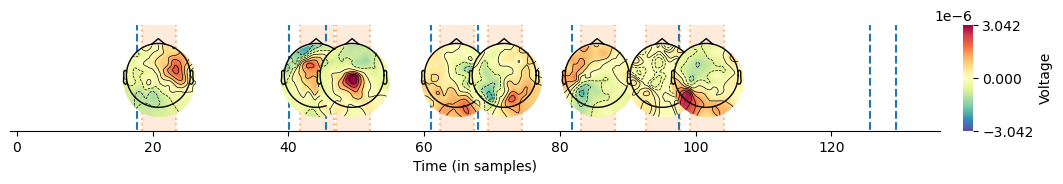

In [5]:
#Fitting
selected = init.fit_single(number_of_events)#function to fit an instance of a 10 events model

#Visualizing
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, init, magnify=1, sensors=False,
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

And we can take a look at the traces from the expectation maximization procedure showing us how many iterations it needed and at what Log-likelihood (LL) it stopped according to the default tolerance on the increase in LL (default 1e-4)

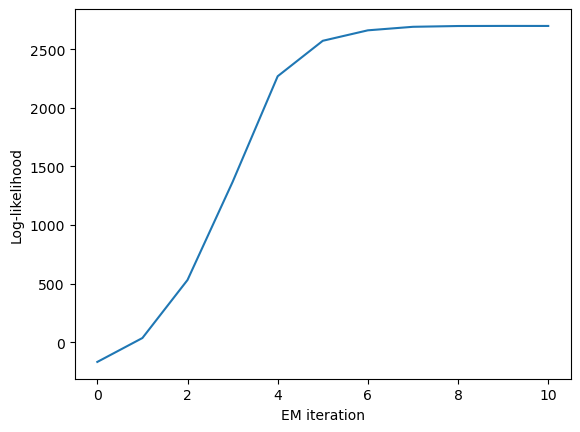

In [6]:
plt.plot(selected.traces)
plt.ylabel('Log-likelihood')
plt.xlabel('EM iteration');


Now launching a single model without additional starting points is not a good idea as often the default starting values (illustrated below) of the expectation maximization algorithm will end up in a local minima: 
 

Estimating 8 events model with 1 starting point(s)
Parameters estimated for 8 events model


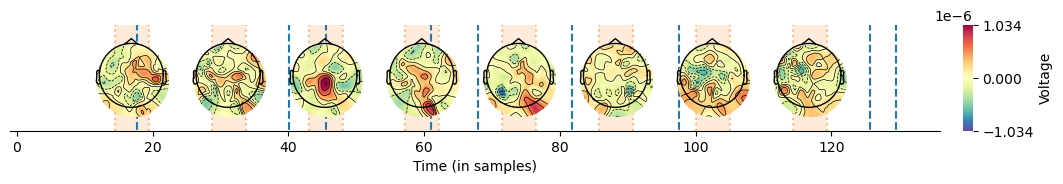

In [7]:
#Fitting
selected = init.fit_single(number_of_events, maximization=False)#function to fit an instance of a 10 events model

#Visualizing
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, init, magnify=1, sensors=False,
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

We need to use more starting points!

## Random method


A better idea is to run a single model with several starting points and selecting the result with the best fit. This can be declared in the ```single_fit()``` function; hereby an example with 100 random starting points.

Estimating 8 events model with 100 starting point(s)
Parameters estimated for 8 events model


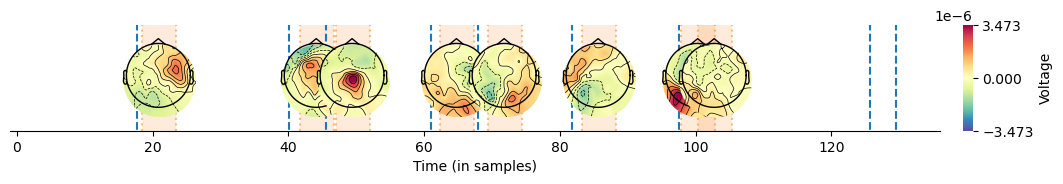

In [8]:
#NOTE: if you run this in VS code on a Mac in an interactive window, you might get strange behavior (running of previous processes) due to the multiprocessing. If so, set your multiprocessing start method to 'fork' (which is the default on Unix) by uncommenting the next two lines:
#import multiprocessing as mp
#mp.set_start_method("fork")

# Fitting
selected = init.fit_single(number_of_events, method='random', starting_points=100)#function to fit an instance of a 4 events model
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, init, magnify=1, sensors=False,
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

But, by definition, the starting points are random so inducing a lot of redundancy and also taking the risk that some points in the parameter space remain unexplored. Several calls to this function will not always give the correct solution.

## Backward estimation

Another solution than using random points is to first estimate a model with the maximal number of possible events (referred to as 'the maximal model'), and then decrease the number of events one by one.

The idea is that genuine events will necessarily be found at the expected locations in the maximal model. Because the backward estimation method iteratively removes the weakest event (in terms of likelihood), only the 'strongest' events remain even if there location would have been hard to find with a single fit and default starting values.

In order to do this we will use the ```backward_estimation()``` function. This function first estimates the maximal model (defined based on the event width and the minimum reaction time), then estimates the max_event - 1 solution by iteratively removing one of the events and picking the next solution with the highest likelihood (for more details see Borst & Anderson, [2021](http://jelmerborst.nl/pubs/ACTR_hmp_MVPA_BorstAnderson_preprint.pdf)) and repeat this until the 1 event solution is reached. 

In [9]:
%%time 
bests = init.backward_estimation(max_events=int(init.compute_max_events()/2)) #/2 to go faster

Estimating all solutions for maximal number of events (12) with 1 pre-defined starting point and 0 random starting points
Estimating all solutions for 11 number of events
Estimating all solutions for 10 number of events
Estimating all solutions for 9 number of events
Estimating all solutions for 8 number of events
Estimating all solutions for 7 number of events
Estimating all solutions for 6 number of events
Estimating all solutions for 5 number of events
Estimating all solutions for 4 number of events
Estimating all solutions for 3 number of events
Estimating all solutions for 2 number of events
Estimating all solutions for 1 number of events
CPU times: user 1.34 s, sys: 605 ms, total: 1.95 s
Wall time: 4.69 s


Here we plot the resulting solutions going from the maximal possible number of events that fit into the minimum RT given a minimum duration of 25ms in this example. 

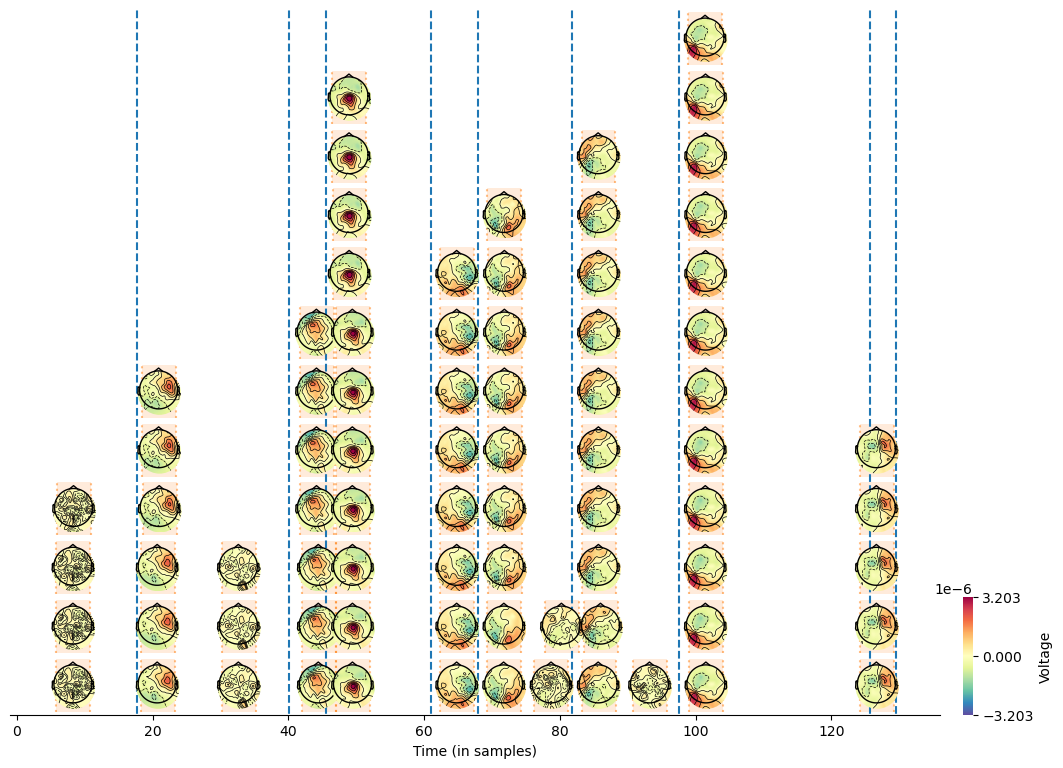

In [10]:
hmp.visu.plot_topo_timecourse(epoch_data, bests, info, init, sensors=False,
                    times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0), magnify=1)

And from these solutions we can then select the number of events we originally wanted to estimate (which is the correct solution in this case):

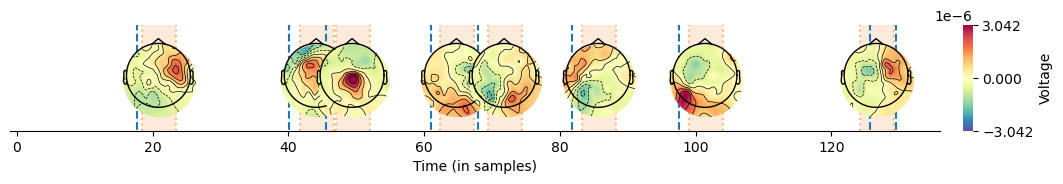

In [11]:
selected = bests.sel(n_events=number_of_events)
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, init, sensors=False,
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0), magnify=1)

The downside is that we are still unsure about whether we included all possible starting points in the mix. In addition, this method can be suboptimal with 1) long RTs and therefore a lot of events to fit and long computation times and 2) if there is a big difference between the minimum RT (determining the maximum number of events) and the mean RT (all possible locations of these events).

# Sliding events

To account for the second point in the previous comment, one possibility is to estimate a single event model and test the landing point in the log-likelihood. The sliding event works by sliding a single event separating the mean reaction time into two stages with the first one ranging from 0 to the mean reaction time. Discontinuities in the resulting log-likelihood usually shows that there is an event around the corresponding times. Note though that it is not a perfect process and a very high variance event can cover a near lower variance event (e.g. between sample number 180 and 250)

Fitting 129 models using grid search


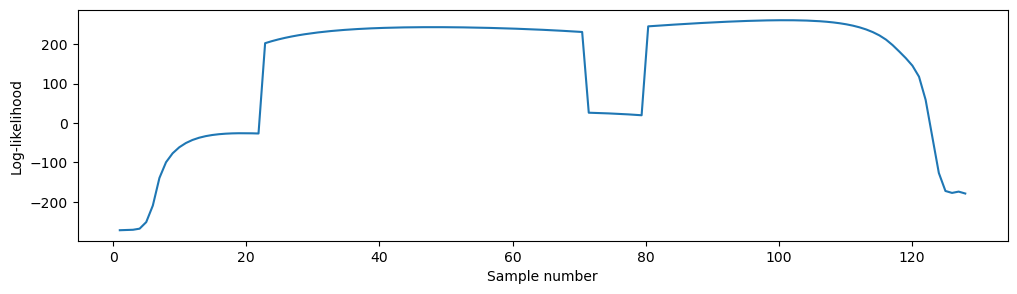

<Axes: xlabel='Sample number', ylabel='Log-likelihood'>

In [12]:
init.sliding_event(fix_pars=True)

Now the previous curve is obtaine by fixing the parameters of the two gammas and only estimating channel contribution but if we relax this constrain:

Fitting 43 models using grid search


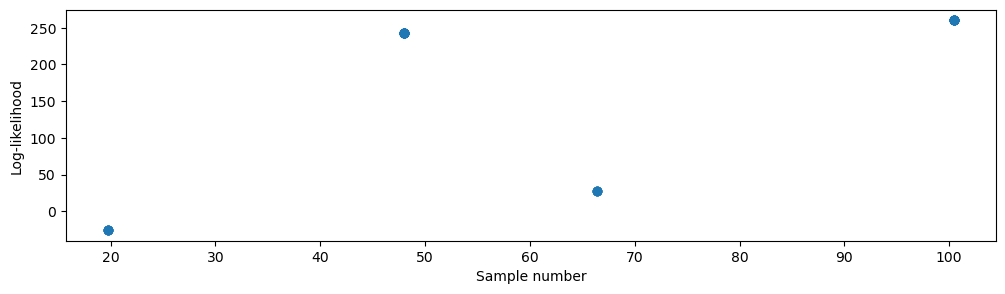

<Axes: xlabel='Sample number', ylabel='Log-likelihood'>

In [13]:
init.sliding_event(fix_pars=False, step=3)#step 3 test every 3rd sample 

Then we see that each sample number used as starting point will go to its nearest local minima. But based on the number of landing points we see, we did not capture all the events that we simulated (8). The reason is that, while we did explore the parameter space of the gammas, we didn't test for different starting points in the channel contributions. If we generate a lot of magnitudes and pass it to the ```sliding_event``` function the landing points look closer to what we expect.

In [14]:
magnitudes_starting_points = init.gen_mags(n_events=1, decimate=3)#decimate reduces the possible number of starting points
magnitudes_starting_points[::2]

Number of potential magnitudes: 81
Because of decimation 27 will be estimated.


array([[[-1., -1., -1., -1.]],

       [[-1., -1.,  1., -1.]],

       [[-1.,  0.,  0., -1.]],

       [[-1.,  1., -1., -1.]],

       [[-1.,  1.,  1., -1.]],

       [[ 0., -1.,  0., -1.]],

       [[ 0.,  0., -1., -1.]],

       [[ 0.,  0.,  1., -1.]],

       [[ 0.,  1.,  0., -1.]],

       [[ 1., -1., -1., -1.]],

       [[ 1., -1.,  1., -1.]],

       [[ 1.,  0.,  0., -1.]],

       [[ 1.,  1., -1., -1.]],

       [[ 1.,  1.,  1., -1.]]])

Fitting 43 models using grid search


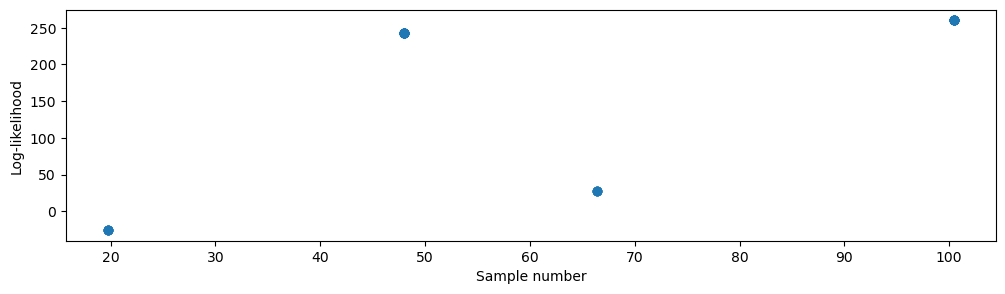

<Axes: xlabel='Sample number', ylabel='Log-likelihood'>

In [15]:
init.sliding_event(magnitudes=magnitudes_starting_points, step=3)

It appears that several landings points appear with some redundancies. To group those points together we use a clustering algorithm and make a choice on the number of clusters based on the grouping quality (Silhouette and visual inspection).

Number of potential magnitudes: 81
Because of decimation 27 will be estimated.


  0%|          | 0/27 [00:00<?, ?it/s]

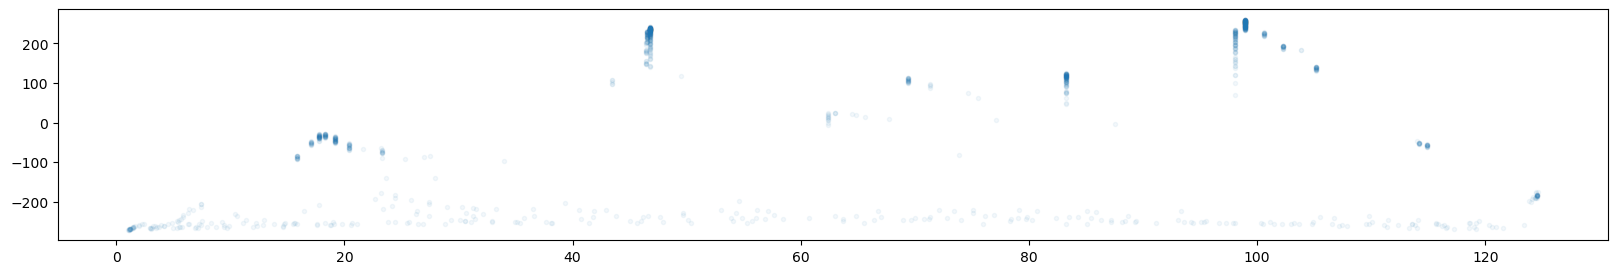

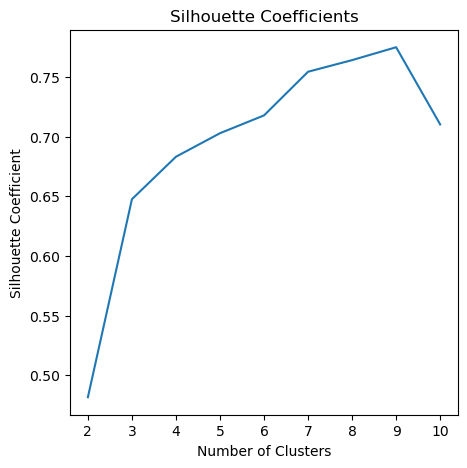

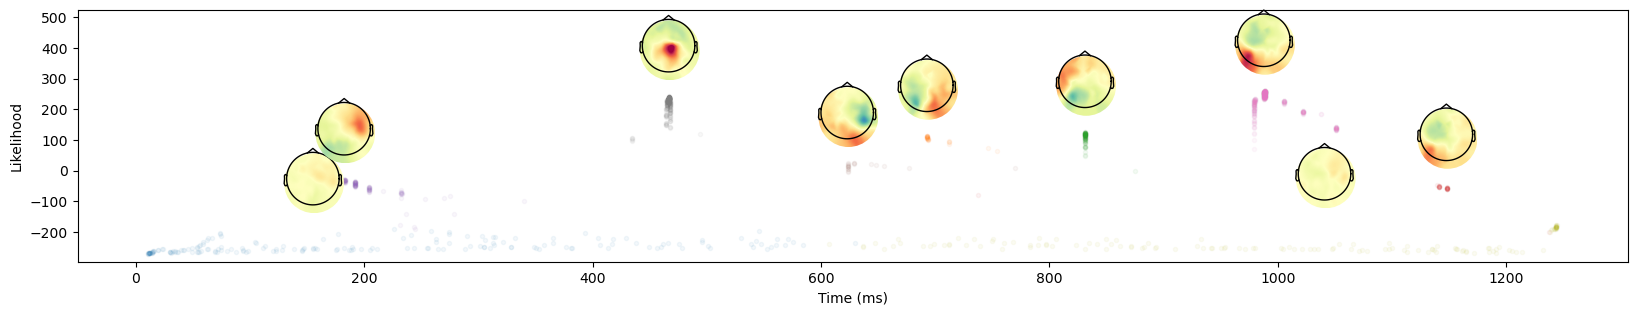

Do you agree with this solution [enter '0'], or would you like to explore a different number of clusters [enter the number of clusters]? 0


Estimating 9 events model
Parameters estimated for 9 events model


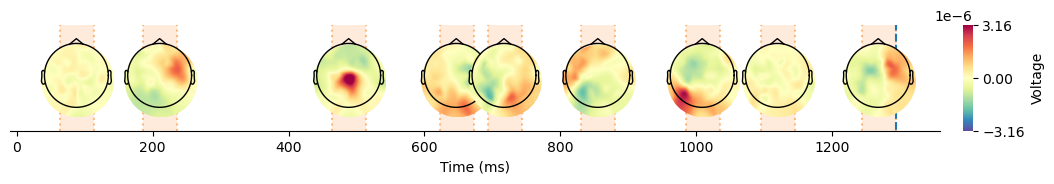

In [16]:
#calc estimates
lkhs, mags, channels, times = init.sliding_event_mags(epoch_data, step=3, decimate_grid = 3, cpu=cpus, plot=True, min_iteration=10)

# cluster in time, lkh, and mags
mags_cl, pars_cl = hmp.clusters.cluster_events(init, lkhs, mags, channels, times, method='time_x_lkh_x_mags', max_clust=10, p_outlier=.05, info=info, calc_outliers=True)

#fit final model
best_estimate = init.fit_single(mags_cl.shape[0], magnitudes=mags_cl,parameters=pars_cl)
hmp.visu.plot_topo_timecourse(epoch_data, best_estimate, info, init, magnify=1, sensors=False, time_step=1000/init.sfreq,xlabel='Time (ms)', contours=0, event_lines=True, colorbar=True)

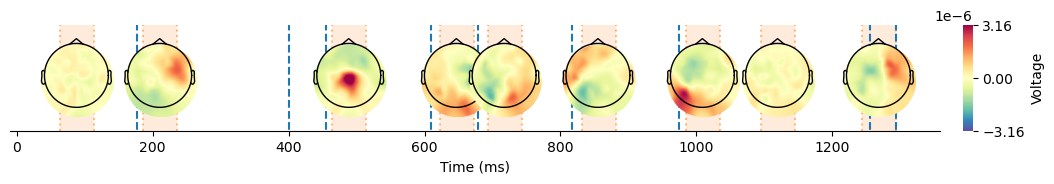

In [17]:
hmp.visu.plot_topo_timecourse(epoch_data, best_estimate, info, init, magnify=1, sensors=False, time_step=1000/init.sfreq, xlabel='Time (ms)', contours=0, event_lines=True, colorbar=True,
                              times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

Now the solution isn't yet perfect and can take quite some time depending on the number of Principal components (and therefore combinations of starting points) and the number of tested clusters. One possible explanation is that not taking into account the previous events makes it harder to detect the next one (probably why we are missing the last one here). Therefore we created a method combining all the properties of this way of exploring the starting points:

## Cumulative event fit

Instead of fitting an _n_ event model, as the ```sliding_event()``` function, this method starts by fitting a 1 event model (two stages) using each sample from the time 0 (stimulus onset) to the mean RT. Therefore it tests for the landing point of the expectation maximization algorithm given each sample as starting point and the likelihood associated with this landing point. As soon as a starting points reaches the convergence criterion, the function fits an _n+1_ event model and uses the next samples in the RT for the following event.

In [18]:
estimates = init.fit()

  0%|          | 0/130 [00:00<?, ?it/s]

Transition event 1 found around sample 20
Transition event 2 found around sample 48
Transition event 3 found around sample 49
Transition event 4 found around sample 66
Transition event 5 found around sample 73
Transition event 6 found around sample 87
Transition event 7 found around sample 104
Transition event 8 found around sample 130
Estimating 8 events model
Parameters estimated for 8 events model


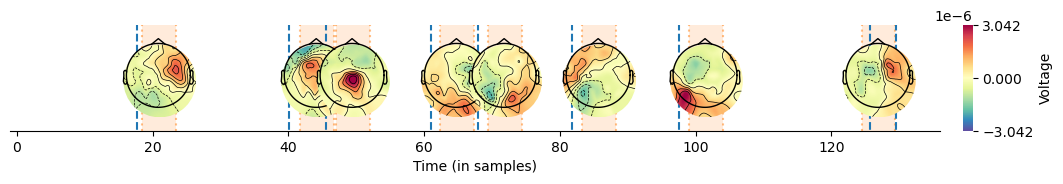

In [19]:
hmp.visu.plot_topo_timecourse(epoch_data, estimates, info, init, 
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0), magnify=1)

# Data saving

Once finished we can save fitted models using the dedicated command

In [21]:
hmp.utils.save_fit(selected, 'selected.nc')

selected.nc saved


<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


And load the same way

In [22]:
estimates = hmp.utils.load_fit('selected.nc')

Or even only save the estimated event probabilities 

In [23]:
hmp.utils.save_eventprobs(selected.eventprobs, 'selected_eventprobs.nc')

Saved at selected_eventprobs.nc
